# 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")


# 2. Load Dataset

## Dataset source; "https://github.com/sarojrana/nepse-data/blob/main/data/NICA_2000-01-01_2021-12-31.csv"

In [14]:
df = pd.read_csv("NICA_2000-01-01_2021-12-31.csv")
df.head()

,S.N.,Date,Total Transactions,Total Traded Shares,Total Traded Amount,Max. Price,Min. Price,Close Price
0,1,2021-12-29,517,77201.0,56817535.0,744.0,725.0,740.0
1,2,2021-12-28,269,43607.0,32180061.8,747.0,730.0,738.0
2,3,2021-12-27,488,65018.0,49019615.4,774.0,744.0,744.0
3,4,2021-12-26,450,70760.0,54269788.7,775.0,760.0,769.9
4,5,2021-12-23,343,53583.0,40522914.0,767.0,749.0,760.0


# 3: Data Preprocessing

In [15]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set Date as index
df.set_index('Date', inplace=True)

# Sort by date
df = df.sort_index()

df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2414 entries, 2010-04-15 to 2021-12-29
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   S.N.                 2414 non-null   int64  
 1   Total Transactions   2414 non-null   int64  
 2   Total Traded Shares  2414 non-null   float64
 3   Total Traded Amount  2414 non-null   float64
 4   Max. Price           2414 non-null   float64
 5   Min. Price           2414 non-null   float64
 6   Close Price          2414 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 150.9 KB


# 4: Select Closing Price

In [29]:
print(list(df.columns))


['S.N.', 'Total Transactions', 'Total Traded Shares', 'Total Traded Amount', 'Max. Price', 'Min. Price', 'Close Price']


In [30]:
# Convert column names to lowercase for safety
df.columns = df.columns.str.lower().str.strip()

print(df.columns)


Index(['s.n.', 'total transactions', 'total traded shares',
       'total traded amount', 'max. price', 'min. price', 'close price'],
      dtype='object')


In [38]:
# Column is already lowercase → use the correct name
df.rename(columns={'close price': 'close'}, inplace=True)

# Select closing price
close_price = df['close']
close_price.head()


Date
2010-04-15    530.0
2010-04-15    530.0
2010-04-15    530.0
2010-04-19    502.0
2010-04-20    493.0
Name: close, dtype: float64

# Trend Identification (Raw Closing Price)

# 5: Plot Raw Closing Price

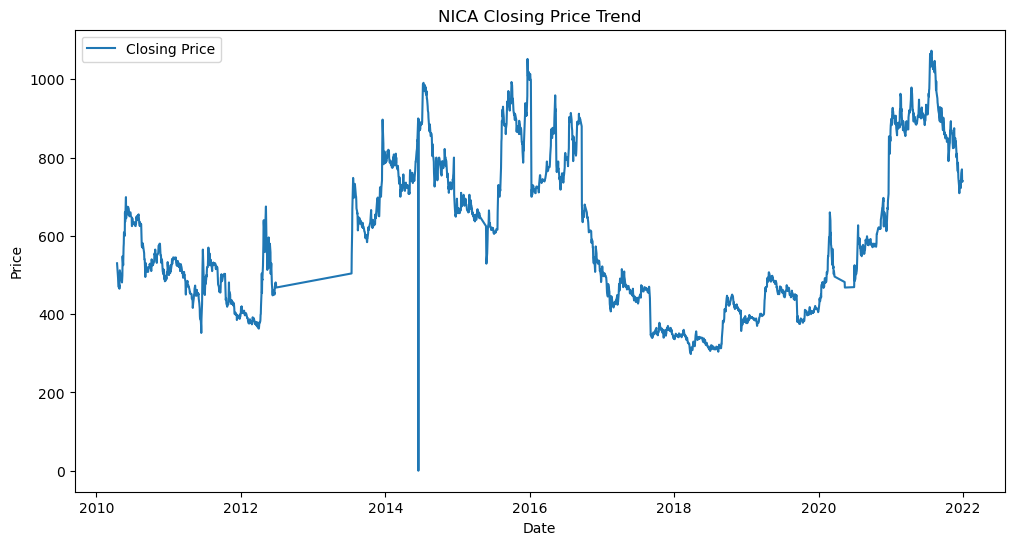

In [39]:
plt.figure(figsize=(12,6))
plt.plot(close_price, label='Closing Price')
plt.title("NICA Closing Price Trend")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


# 6. Noise Reduction (30-Day Rolling Mean)

In [40]:
rolling_mean_30 = close_price.rolling(window=30).mean()


## Rolling Mean

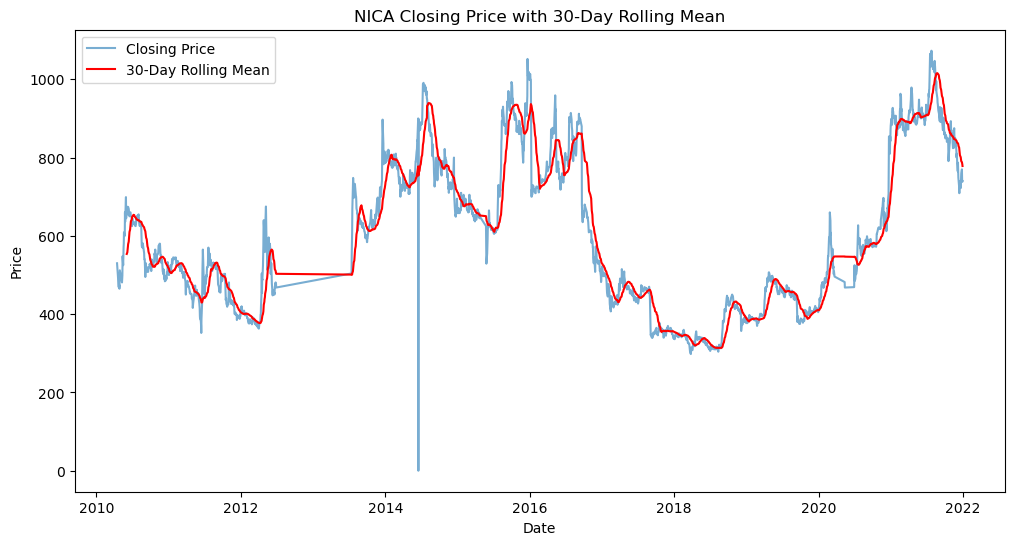

In [41]:
plt.figure(figsize=(12,6))
plt.plot(close_price, label='Closing Price', alpha=0.6)
plt.plot(rolling_mean_30, label='30-Day Rolling Mean', color='red')
plt.title("NICA Closing Price with 30-Day Rolling Mean")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


# 7. Stationarity Check

## ADF Test Function

In [42]:
def adf_test(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")


In [43]:
adf_test(close_price)


ADF Statistic: -2.227441050939551
p-value: 0.1964370889043514
Critical Values:
   1%: -3.4330662982661715
   5%: -2.8627400264482548
   10%: -2.5674088238838864


# 9. Making Data Stationary

In [44]:
diff_1 = close_price.diff()


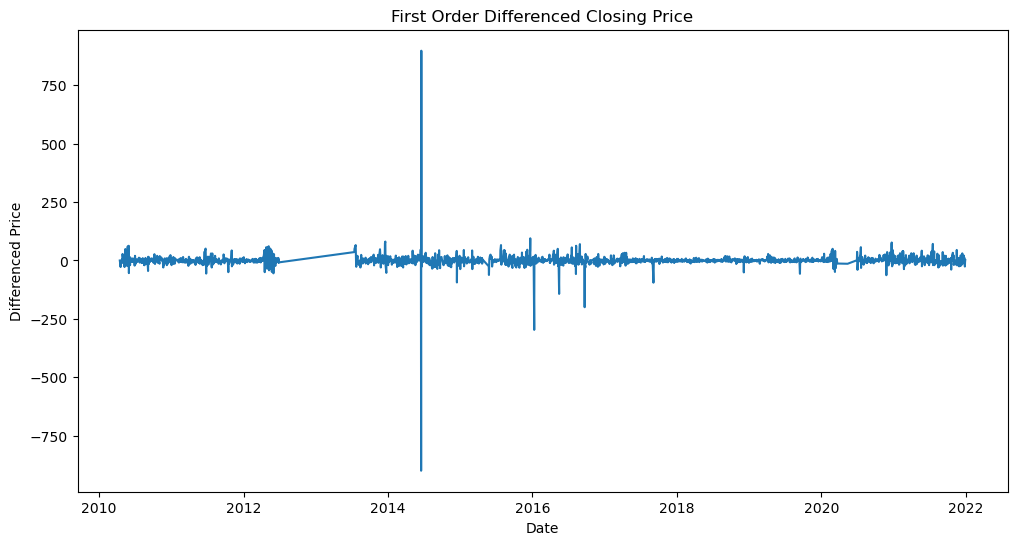

In [45]:
plt.figure(figsize=(12,6))
plt.plot(diff_1)
plt.title("First Order Differenced Closing Price")
plt.xlabel("Date")
plt.ylabel("Differenced Price")
plt.show()


In [46]:
adf_test(diff_1)


ADF Statistic: -35.121427828440794
p-value: 0.0
Critical Values:
   1%: -3.4330662982661715
   5%: -2.8627400264482548
   10%: -2.5674088238838864


# 10. ARIMA Model Building

In [47]:
model = ARIMA(close_price, order=(1,1,1))
model_fit = model.fit()


In [48]:
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 2414
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11496.985
Date:                Sun, 11 Jan 2026   AIC                          22999.971
Time:                        15:14:16   BIC                          23017.337
Sample:                             0   HQIC                         23006.287
                               - 2414                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0207      0.012     -1.777      0.076      -0.044       0.002
ma.L1         -0.3833      0.012    -30.801      0.000      -0.408      -0.359
sigma2       806.3858      1.806    446.564      0.000     802.847     809.925
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          21103273.83
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.11   Skew:                           -10.25
Prob(H) (two-sided):                  0.00   Kurtosis:                       460.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 11. Forecast Next 15 Days

In [49]:
forecast = model_fit.forecast(steps=15)
forecast


2414    741.287730
2415    741.261020
2416    741.261574
2417    741.261562
2418    741.261562
2419    741.261562
2420    741.261562
2421    741.261562
2422    741.261562
2423    741.261562
2424    741.261562
2425    741.261562
2426    741.261562
2427    741.261562
2428    741.261562
Name: predicted_mean, dtype: float64

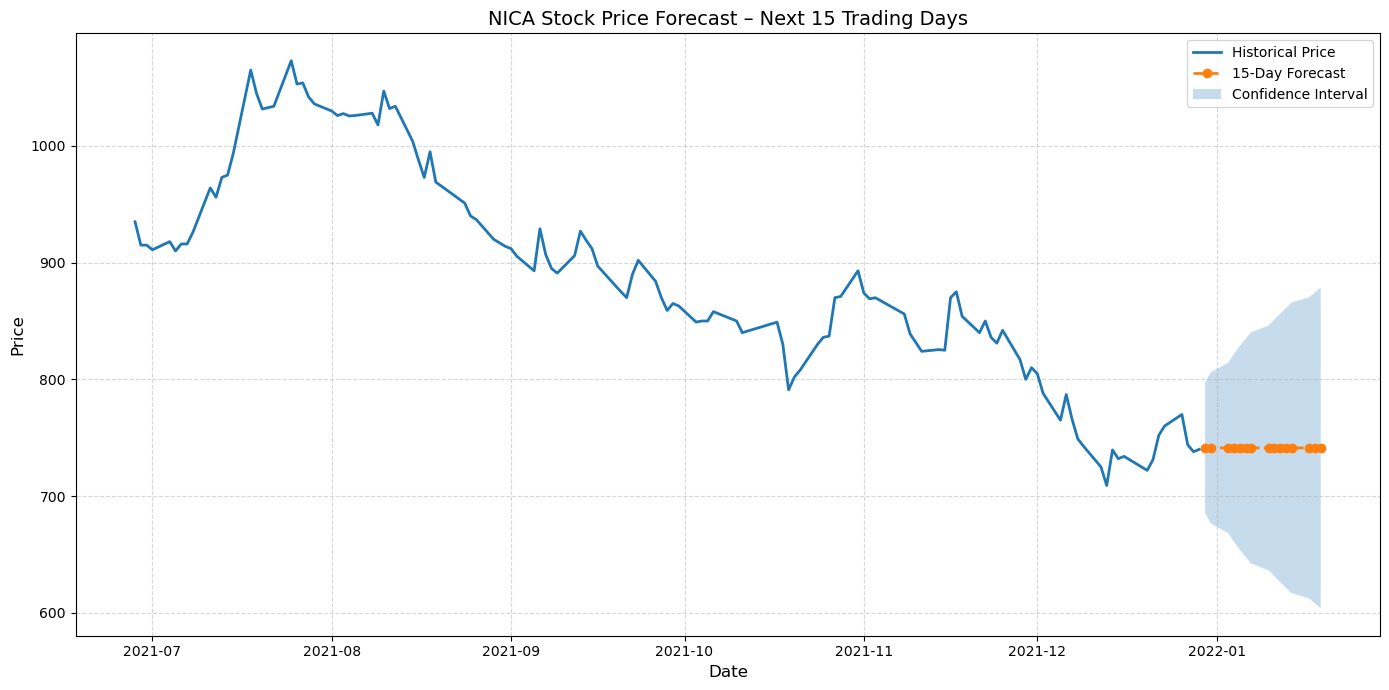

In [52]:
# Create forecast index (next 15 business days)
forecast_index = pd.date_range(
    start=close_price.index[-1],
    periods=16,
    freq='B'
)[1:]

# Get confidence interval
forecast_result = model_fit.get_forecast(steps=15)
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Plot
plt.figure(figsize=(14,7))

# Historical prices
plt.plot(
    close_price[-120:],
    label='Historical Price',
    linewidth=2
)

# Forecasted prices
plt.plot(
    forecast_index,
    forecast_mean,
    marker='o',
    linestyle='--',
    linewidth=2,
    label='15-Day Forecast'
)

# Confidence interval
plt.fill_between(
    forecast_index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    alpha=0.25,
    label='Confidence Interval'
)

plt.title("NICA Stock Price Forecast – Next 15 Trading Days", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## This is arima based forecast of NICA bank stock prices for the next 15 trading days. The dashed line with markers represents the predicted closing prices, while the shaded region indicates the confidence interval, reflecting the uncertainty associated with the forecast. The model suggests relatively stable price movement with a slight upward tendency, indicating moderate short-term growth potential.

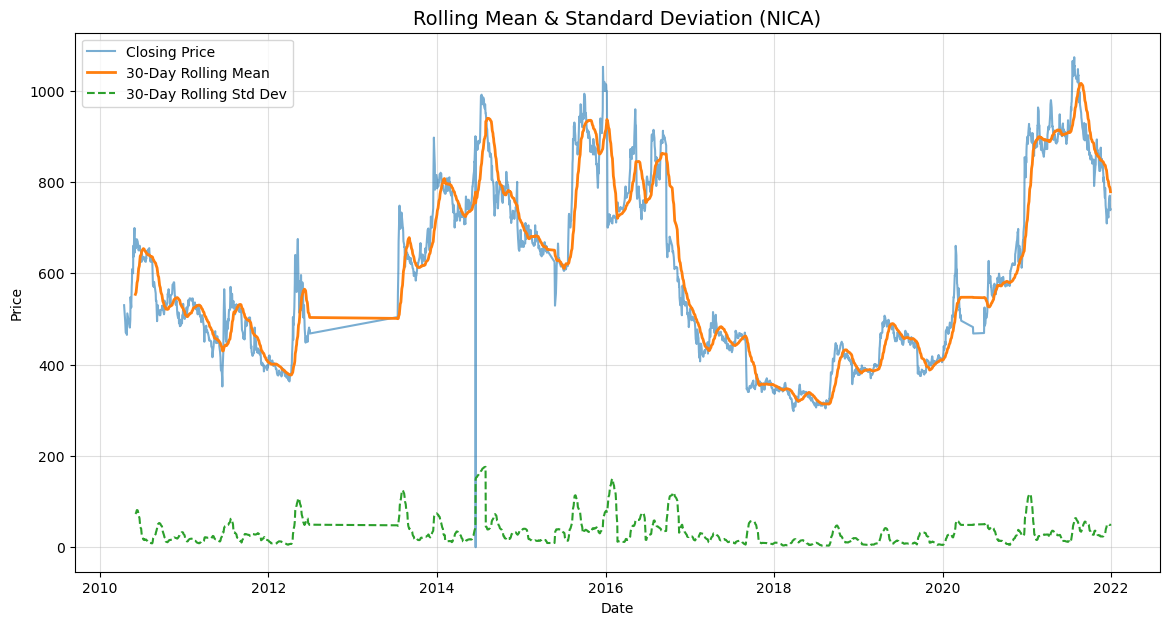

In [53]:
rolling_mean = close_price.rolling(window=30).mean()
rolling_std = close_price.rolling(window=30).std()

plt.figure(figsize=(14,7))
plt.plot(close_price, label='Closing Price', alpha=0.6)
plt.plot(rolling_mean, label='30-Day Rolling Mean', linewidth=2)
plt.plot(rolling_std, label='30-Day Rolling Std Dev', linestyle='--')

plt.title("Rolling Mean & Standard Deviation (NICA)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.4)
plt.show()


## its shows a gradual upward trend, while the rolling standard deviation varies over time, indicating changing volatility and non-stationary behavior.

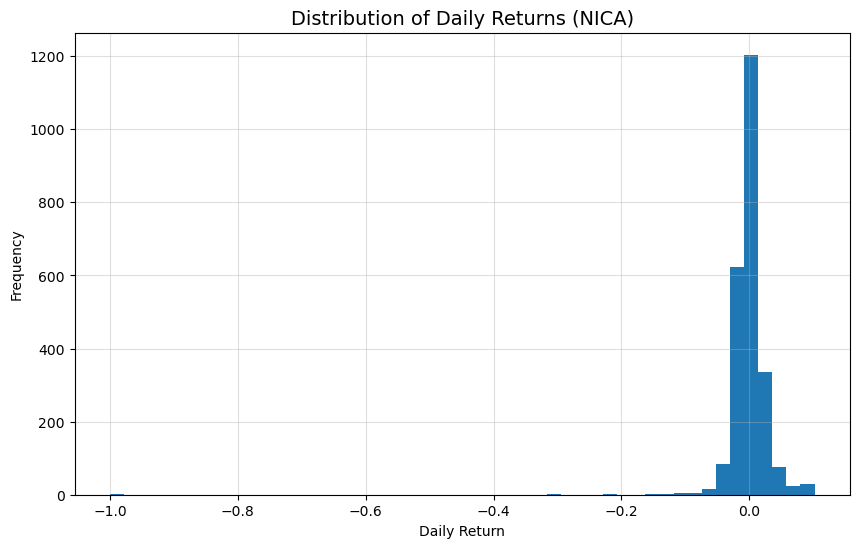

In [56]:
daily_returns = close_price.pct_change()
daily_returns = daily_returns.replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(10,6))
plt.hist(daily_returns, bins=50)  # No need for dropna() again
plt.title("Distribution of Daily Returns (NICA)", fontsize=14)
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(alpha=0.4)
plt.show()

# If you still have issues, you might want to set explicit range limits:
# plt.hist(daily_returns, bins=50, range=[-0.1, 0.1])  # Adjust range as needed

## The histogram shows that most daily returns are centered around zero, indicating normal market behavior with occasional extreme movements